**Amaç : Belirli bir kelimeyi takip ederek bir sonraki kelimeyi tahmin eden bir model oluşturmak (Boşluk doldurma gibi)

##1-İMPORTİNG LİBRARİES

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

##2-Get The Data

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2023-03-10 13:11:26--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.4.139, 142.250.4.113, 142.250.4.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hi0p2eh6o045q4msasjt7mmcrf4tt566/1678453875000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=33957a62-e145-40a7-ad9f-8510de0fa941 [following]
--2023-03-10 13:11:29--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hi0p2eh6o045q4msasjt7mmcrf4tt566/1678453875000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=33957a62-e145-40a7-ad9f-8510de0fa941
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connecting to doc-04-ak-d

**VERİ SETİMİZDEKİ 10 ŞARKI SÖZÜNE BAKALIM**

##3-PREPROCESSİNG
 1. Noktalama işaretlerini kaldıracaz
 2. Harfleri küçülteceğiz
 3. Satır satır yazdıracaz


In [3]:
def tokenize_corpus(corpus,num_words = -1): # corpus : Külliyat
  # corpusu tokenize edelim
  if num_words > -1:
    tokenizer = Tokenizer(num_words = num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer


def create_lyrics_corpus(dataset,field):
  # Tüm noktalama işlemlerini kaldıralım
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation),'')  #punctuation : noktalama
  # harfleri küçültelim
  dataset[field] = dataset[field].str.lower()
  # satırlara bölmek için uzun bir dize yapalım
  lyrics =dataset[field].str.cat()
  corpus = lyrics.split("\n")
  # Sonlarındaki boşlukları kaldıralım
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # boş olan satırları kaldıralım
  corpus  = [l for l in corpus if l !='']
  return corpus


In [4]:
# datasetimizi okuyalım (10 tane alalım)
dataset = pd.read_csv('/tmp/songdata.csv',dtype = str)[:10]
# text kısmını alıyoruz
corpus = create_lyrics_corpus(dataset,'text')

# tokenize corpus 
tokenizer =tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) +1 

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'and': 3, 'a': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'ma': 10, 'it': 11, 'of': 12, 'im': 13, 'your': 14, 'love': 15, 'so': 16, 'as': 17, 'that': 18, 'in': 19, 'andante': 20, 'boomaboomerang': 21, 'make': 22, 'on': 23, 'oh': 24, 'for': 25, 'but': 26, 'new': 27, 'bang': 28, 'its': 29, 'be': 30, 'like': 31, 'know': 32, 'now': 33, 'how': 34, 'could': 35, 'youre': 36, 'sing': 37, 'never': 38, 'no': 39, 'chiquitita': 40, 'can': 41, 'we': 42, 'song': 43, 'had': 44, 'good': 45, 'youll': 46, 'she': 47, 'just': 48, 'girl': 49, 'again': 50, 'will': 51, 'take': 52, 'please': 53, 'let': 54, 'am': 55, 'eyes': 56, 'was': 57, 'always': 58, 'cassandra': 59, 'blue': 60, 'time': 61, 'dont': 62, 'were': 63, 'return': 64, 'once': 65, 'then': 66, 'sorry': 67, 'cryin': 68, 'over': 69, 'feel': 70, 'ever': 71, 'believe': 72, 'what': 73, 'do': 74, 'go': 75, 'all': 76, 'out': 77, 'think': 78, 'every': 79, 'leave': 80, 'look': 81, 'at': 82, 'way': 83, 'one': 84, 'music': 85, 'down': 

<ipython-input-3-d62abbe1e732>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation),'')  #punctuation : noktalama


##4-CREATE SEQUENCES AND LABELS

In [5]:
sequences =[]

for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_sequences = token_list[:i+1]
    sequences.append(n_gram_sequences)



## padding işlemleri
# en uzun cümlenin kelime sayısını bulalım
# padding işlemini en uzun cümleye göre dolduralım

max_sequences_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences,maxlen =max_sequences_len,padding='pre')) # 'pre' 0 ları başa koy

# girdi ve çıktı olarak ayıralım (input = input_sequences,output = labels)
input_sequences,labels = sequences[:,:-1],sequences[:,-1]

# Etiketleri 0-1 e  dönüştürelim
one_hot_labels = tf.keras.utils.to_categorical(labels,num_classes =total_words)



In [6]:
# Belirlediğimiz kelimelerin hangi değeri aldığını görelim
print("Word index is value :",tokenizer.word_index['know'])
print("Word index is value :",tokenizer.word_index['feeling'])
# Girdi dizilerinin tokenize şekline bakalım
print("İnput :",input_sequences[5])
print("İnput :",input_sequences[6])
# Obe hot encoding hallerine bakalım
print(one_hot_labels[5])
print(one_hot_labels[6])

Word index is value : 32
Word index is value : 97
İnput : [  0   0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29
   4]
İnput : [  0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29   4
 287]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

##5-CREATE AND FİT TEXT GENERATE MODEL
  * RNN model yapısına benzer
  * loss = 'vategorical_crossentropy' kullanılacak(0 ve 1 den başka değerler bulunduğu için)
  

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequences_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
62/62 [==============================] - 15s 76ms/step - loss: 6.0462 - accuracy: 0.0197
Epoch 2/200
62/62 [==============================] - 1s 17ms/step - loss: 5.4479 - accuracy: 0.0399
Epoch 3/200
62/62 [==============================] - 1s 17ms/step - loss: 5.3603 - accuracy: 0.0444
Epoch 4/200
62/62 [==============================] - 1s 17ms/step - loss: 5.2977 - accuracy: 0.0419
Epoch 5/200
62/62 [==============================] - 0s 7ms/step - loss: 5.2199 - accuracy: 0.0404
Epoch 6/200
62/62 [==============================] - 1s 14ms/step - loss: 5.1452 - accuracy: 0.0444
Epoch 7/200
62/62 [==============================] - 1s 12ms/step - loss: 5.0772 - accuracy: 0.0454
Epoch 8/200
62/62 [==============================] - 0s 7ms/step - loss: 5.0140 - accuracy: 0.0651
Epoch 9/200
62/62 [==============================] - 1s 9ms/step - loss: 4.9471 - accuracy: 0.0636
Epoch 10/200
62/62 [==============================] - 1s 10ms/step - loss: 4.8780 - accuracy: 0.0843
E

##6-Visualize accuracy

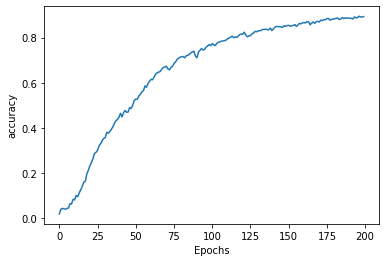

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

##7-Generate new lyrics
  * Şimdi modelimizi belirli bir doğrulukla eğittik
  * Yeni sözler üretimine başlayacağız
  * İlk olarak anahtar bir kelime verecez (seed_text)
  * sonrasında metinimizin en fazla ne kadar uzunlukta olması gerektiğini söyleyeceğiz(sonsuzda olabilir).Biz 100 kelime olarak belirleyeceğiz(next_words = 100)

In [11]:
seed_text = "im feeling chills"
next_words = 100
  
for a in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequences_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 26ms/step
im feeling chills me to the bone up will cause me strong mad be sailing sailing touch touch night tedious little little little little little little little little little little little little little little little little little little little power am standing just just just just just just just just just just just just just just just too walk too walk too walk too walk eye walls new walk too too eye walk just past past feeling sucker fingers feeling think ride baby think walk darkest life think fingers truth truth final night tedious tough me touch touch tedious little little little touch
